In [2]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *
from skimage import filters
from skimage.util import random_noise


In [3]:
# Modify accordingly
path = Path('/home/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/')

dataset_name = 'semi-synthetic_tSEM'

lr_name = f'training/trainsets/crappified/'
lr_path = path/f'{lr_name}'
lr_files = list(lr_path.glob('*.tif'))

hr_name = f'training/trainsets/hr/'
hr_path = path/f'{hr_name}'
hr_files = list(hr_path.glob('*.tif'))

print('Processing '+str(len(lr_files))+' files...')

Processing 99997 files...


In [4]:
def get_data(x_train, y_train):
    def map_to_hr(x):
        return Path(str(y_train/x.relative_to(x_train).with_suffix(".tif")).replace('lr', 'hr'))
    src = (ImageImageList
          .from_folder(x_train, convert_mode="L")
          .split_none()
          .label_from_func(map_to_hr, convert_mode="L"))
    return src

In [5]:
d = get_data(lr_path, hr_path)

In [6]:
d.train

LabelList (99997 items)
x: ImageImageList
Image (1, 150, 225),Image (1, 150, 225),Image (1, 150, 225),Image (1, 150, 225),Image (1, 150, 225)
y: ImageList
Image (1, 600, 900),Image (1, 600, 900),Image (1, 600, 900),Image (1, 600, 900),Image (1, 600, 900)
Path: /home/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/crappified

In [7]:
def _my_noise(x, gauss_sigma:uniform=0.01, pscale:uniform=10):
    xn = x.numpy()
    xorig_max = xn.max()

    xn = random_noise(xn, mode='salt', amount=0.005)
    xn = random_noise(xn, mode='pepper', amount=0.005)
    lvar = filters.gaussian(x, sigma=5) + 1e-10
    xn = random_noise(xn, mode='localvar', local_vars=lvar*0.5)
    #xn = np.random.poisson(xn*pscale)/pscale
    #xn += np.random.normal(0, gauss_sigma*xn.std(), size=x.shape)
    x = x.new(xn)
    new_max = xn.max()
    if new_max > 0:
        xn /= new_max
    xn *= xorig_max
    return x


my_noise = TfmPixel(_my_noise)

In [13]:
def get_xy_transforms(max_rotate=10., min_zoom=1., max_zoom=4., use_cutout=False, use_noise=False, xtra_tfms=None,
                      gauss_sigma=(0.4,0.7), pscale=(5,30)):
    base_tfms = [[
            rand_crop(),
            dihedral_affine(),
            rotate(degrees=(-max_rotate,max_rotate)),
            rand_zoom(min_zoom, max_zoom)],
        [crop_pad()]]

    y_tfms = [[tfm for tfm in base_tfms[0]], [tfm for tfm in base_tfms[1]]]
    x_tfms = [[tfm for tfm in base_tfms[0]], [tfm for tfm in base_tfms[1]]]
    if use_cutout: x_tfms[0].append(cutout(n_holes=(5,10)))
    if use_noise:
        x_tfms[0].append(my_noise(gauss_sigma=gauss_sigma, pscale=pscale))
        #x_tfms[1].append(my_noise(gauss_sigma=(0.01,0.05),pscale=(5,30)))

    if xtra_tfms:
        for tfm in xtra_tfms:
            x_tfms[0].append(tfm)

    return x_tfms, y_tfms

In [14]:
def process_data(data, bs=8, size=256, scale=4, num_workers=4):
    x_tfms, y_tfms = get_xy_transforms()
    x_sz = size // scale
    
    data = (data.transform(x_tfms, size=x_sz)
               .transform_y(y_tfms, size=size)
               .databunch(bs=bs, num_workers=num_workers)
               .normalize(do_y=True))
    return data

In [15]:
db = process_data(d)

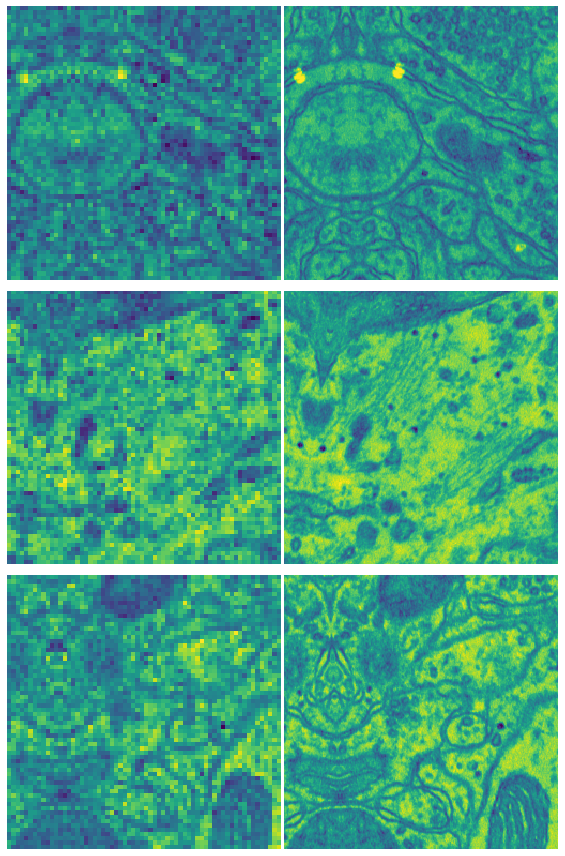

In [16]:
db.show_batch(rows=3)

In [ ]:
fastai.__version__